In [44]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display


import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [45]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [46]:
#notes = np.array(tf.io.gfile.listdir(str(data_dir)))
notes = np.array(['A','G#','G','F#','F','E','D#','D','C#','C','B','A#'])
print('Notes:', notes)

Notes: ['A' 'G#' 'G' 'F#' 'F' 'E' 'D#' 'D' 'C#' 'C' 'B' 'A#']


#### Предварительная проверка файлов на соответствие размеру окна

In [47]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label_check(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label, file_path

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [49]:
files_ds = tf.data.Dataset.from_tensor_slices(filenames)
output_ds = files_ds.map(get_waveform_and_label_check, num_parallel_calls=AUTOTUNE)

In [50]:
data = []
lengths = []
for a,b,c in output_ds:
    data.append((a.shape[0],b,c))
    lengths.append(a.shape[0])

In [51]:
idx_yes = [] #список индексов файлов с подходящими размерами
idx_no = [] #список индексов файлов с неподходящими размерами 
for a in range(len(lengths)):
    if lengths[a]<8192:
        idx_no.append(a)
    else:
        idx_yes.append(a)
            
print(len(idx_yes))
print(len(idx_no))
print(len(idx_yes)+len(idx_no))

27310
3518
30828


In [52]:
filenames_filtered = []
for i in range(len(filenames)):
    if i in idx_yes:
        filenames_filtered.append(filenames[i])
len(filenames_filtered)

27310

_________________________

In [53]:
filenames = tf.random.shuffle(filenames_filtered)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 27310
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F\\kr033a_150.wav', shape=(), dtype=string)


In [54]:
# Для удобства разбиения выборки на тренировочную, тестовую и валидационную возьмем только 27000 файлов, 
# которые разобьем в соотношении 70:20:10 

filenames = filenames[:27000]

train_files = filenames[:18900]
val_files = filenames[18900: 18900 + 5400]
test_files = filenames[-2700:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 18900
Validation set size 5400
Test set size 2700


In [55]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11507, 1])

In [56]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [57]:
# Загружаем триангулярные фильтры
with open('filters.npy', 'rb') as f:
    fbank = np.load(f)
    
fbank = tf.convert_to_tensor(fbank.T, dtype=tf.float32)   
print(fbank.shape)

(4097, 40)


In [58]:
def get_spectrogram(params):
    waveform = params[0]
    S = tf.convert_to_tensor(params[1])
    NFFT = 8192
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=2048, frame_step=S,fft_length=NFFT,pad_end=False)
    spectrogram = tf.abs(spectrogram)
    pow_frames = ((1.0 / NFFT) * ((spectrogram) ** 2))
    filter_banks = tf.tensordot(pow_frames, fbank, axes = [[1], [0]])
    filter_banks = tf.where(filter_banks == 0, tf.keras.backend.epsilon(), filter_banks)  # Численная стабильность 
    # tf.keras.backend.epsilon() - машинный ноль)
    spectrogram = tf.math.log(filter_banks)  # Логарифмические энергии набора фильтров
    spectrogram = tf.signal.dct(spectrogram, type=2, axis=-1, norm='ortho')

    return spectrogram

In [59]:
def plot_spectrogram(spectrogram, ax):
    # Преобразуем в частоты для логарифмической шкалы и транспонируем так, чтобы время
    # было представлено на оси x (столбцы). Эпсилон добавляется, чтобы избежать нуля.
    height = spectrogram.shape[1]
    width = spectrogram.shape[0]
    #X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    X = np.array(range(width))
    Y = np.array(range(height))
    ax.pcolormesh(X, Y, spectrogram.T)

In [60]:
def get_spectrogram_and_label_id(audio, label, step):
    spectrogram = get_spectrogram((audio,step))
    #spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_lim(spectrogram, label_id, M):
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
    return spectrogram, label_id

In [61]:
def preprocess_dataset(files,s,f):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,s), num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,f))
    return output_ds

In [62]:
def create_model(input_shape):
    inputs = layers.Input(shape = input_shape, name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [63]:
K = 8192
step = list(map(int,[K/32, K/16, K/8, K/4, K/2, K]))
num_frame = [5,10,15,20,25,30]
params_s_f = [] 

for s in step:
    for f in num_frame:
        params_s_f.append((s,f))
print('Количество вариантов step', len(step))
print('Количество вариантов num_frame', len(num_frame))
print('Количество баз данных', len(params_s_f))

Количество вариантов step 6
Количество вариантов num_frame 6
Количество баз данных 36


In [64]:
import time
EPOCHS = 300
batch_size = 64

In [22]:
from datetime import datetime
import pickle

k=0
print('---------------------------------------------------------------------')
print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

start_time = time.time()
print('Подготовка данных...')
spectr = None
train_ = None
val_ = None
test_ = None
input_shape = None
spectr = preprocess_dataset(train_files,params_s_f[k][0],params_s_f[k][1])
train_=spectr
val_ = preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1])
test_ = preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1])
for spectrogram, _ in spectr.take(1):
    input_shape = spectrogram.shape
print('Размер входных данных: ', input_shape)
train_ = train_.batch(batch_size)
train_ = train_.cache().prefetch(AUTOTUNE)
val_ = val_.batch(batch_size)
val_ = val_.cache().prefetch(AUTOTUNE)

test_audio = []
test_labels = []
for audio, label in test_:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")
mymodel = create_model(input_shape)
print('Обучение...') 
start_time = time.time()
myhistory = mymodel.fit(train_, validation_data=val_, epochs=50, verbose=1)
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100

print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')



---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  5
2022-06-09 09:15:02
Подготовка данных...
Размер входных данных:  (5, 40)
--- 0.0 минут 9.92893671989441 секунд ---
Обучение...
Epoch 1/50
296/296 [==============================] - 75s 253ms/step - loss: 1.0621 - accuracy: 0.6937 - val_loss: 0.7666 - val_accuracy: 0.7628
Epoch 2/50
296/296 [==============================] - 2s 5ms/step - loss: 0.7268 - accuracy: 0.7732 - val_loss: 0.7088 - val_accuracy: 0.7793
Epoch 3/50
296/296 [==============================] - 2s 5ms/step - loss: 0.6806 - accuracy: 0.7897 - val_loss: 0.6809 - val_accuracy: 0.7907
Epoch 4/50
296/296 [==============================] - 2s 5ms/step - loss: 0.6532 - accuracy: 0.7978 - val_loss: 0.6833 - val_accuracy: 0.7891
Epoch 5/50
296/296 [==============================] - 2s 5ms/step - loss: 0.6253 - accuracy: 0.8070 - val_loss: 0.6881 - val_accuracy: 0.7930
Epoch 6/50
296/296 [==============================]

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная')]

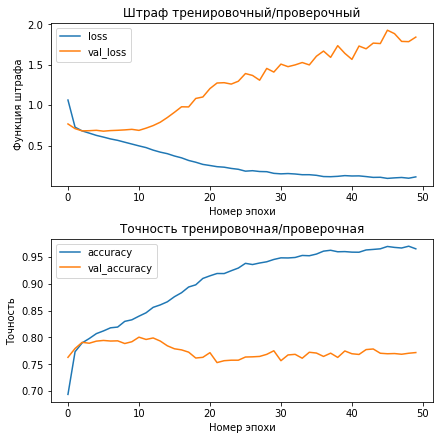

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(myhistory.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(myhistory.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

In [65]:
from datetime import datetime
import pickle

tests_acc = []
for k in range(len(params_s_f)):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    start_time = time.time()
    print('Подготовка данных...')
    spectr = None
    train_ = None
    val_ = None
    test_ = None
    input_shape = None
    spectr = preprocess_dataset(train_files,params_s_f[k][0],params_s_f[k][1])
    train_=spectr
    val_ = preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1])
    test_ = preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1])
    for spectrogram, _ in spectr.take(1):
        input_shape = spectrogram.shape
    print('Размер входных данных: ', input_shape)
    train_ = train_.batch(batch_size)
    train_ = train_.cache().prefetch(AUTOTUNE)
    val_ = val_.batch(batch_size)
    val_ = val_.cache().prefetch(AUTOTUNE)
    
    test_audio = []
    test_labels = []
    for audio, label in test_:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())
    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)
    
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    mymodel = create_model(input_shape)
    print('Обучение...') 
    start_time = time.time()
    myhistory = mymodel.fit(train_, validation_data=val_, epochs=EPOCHS, verbose=0,
                            callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    
    mymodel.save(f"model_mfcc_{k}.h5")
    
    with open(f'./history_mfcc_{k}_epoch.data', 'wb') as filehandle:
        # сохраняем данные как двоичный поток
        pickle.dump(myhistory.epoch, filehandle)

    with open(f'./history_mfcc_{k}_history.data', 'wb') as filehandle:
        # сохраняем данные как двоичный поток
        pickle.dump(myhistory.history, filehandle)



---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  5
2022-06-09 16:12:37
Подготовка данных...
Размер входных данных:  (5, 40)
--- 0.0 минут 8.684770584106445 секунд ---
Обучение...
--- 1.0 минут 42.345550298690796 секунд ---
85/85 [==============================] - 0s 3ms/step
Шаг: 256 , количество спектрограмм:  5 , accuracy тестовой выборки:  83.0 %
---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  10
2022-06-09 16:14:28
Подготовка данных...
Размер входных данных:  (10, 40)
--- 0.0 минут 8.542935371398926 секунд ---
Обучение...
--- 2.0 минут 0.646334171295166 секунд ---
85/85 [==============================] - 0s 4ms/step
Шаг: 256 , количество спектрограмм:  10 , accuracy тестовой выборки:  86.62962962962963 %
---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  15
2022-06-09 16:16:38
Подготовка данных...
Размер входных

Размер входных данных:  (10, 40)
--- 0.0 минут 2.437551975250244 секунд ---
Обучение...
--- 0.0 минут 57.80325245857239 секунд ---
85/85 [==============================] - 0s 4ms/step
Шаг: 2048 , количество спектрограмм:  10 , accuracy тестовой выборки:  91.48148148148148 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  15
2022-06-09 16:40:47
Подготовка данных...
Размер входных данных:  (15, 40)
--- 0.0 минут 2.527221202850342 секунд ---
Обучение...
--- 0.0 минут 51.13933777809143 секунд ---
85/85 [==============================] - 0s 3ms/step
Шаг: 2048 , количество спектрограмм:  15 , accuracy тестовой выборки:  91.77777777777779 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  20
2022-06-09 16:41:41
Подготовка данных...
Размер входных данных:  (20, 40)
--- 0.0 минут 2.5065677165985107 секунд ---
Обучение...
--- 0.0 минут 51.555495262145996 секунд ---
85/85 [======

In [66]:
spectr = None
train_ = None
val_ = None
test_ = None
input_shape = None
test_audio = None
test_labels = None
myhistory = None
mymodel = None

In [67]:
np.array(tests_acc)

array([83.        , 86.62962963, 86.14814815, 89.22222222, 89.96296296,
       92.7037037 , 86.33333333, 89.03703704, 92.51851852, 92.59259259,
       92.59259259, 93.88888889, 89.48148148, 92.77777778, 94.03703704,
       93.48148148, 92.25925926, 92.        , 93.44444444, 91.48148148,
       91.77777778, 90.85185185, 92.11111111, 90.18518519, 92.66666667,
       91.74074074, 92.81481481, 88.85185185, 90.22222222, 91.11111111,
       87.        , 86.33333333, 82.85185185, 83.88888889, 81.77777778,
       83.77777778])

Text(51.0, 0.5, 'Шаг')

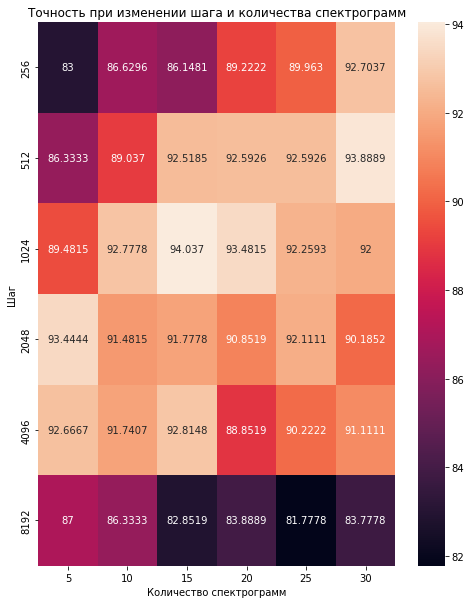

In [68]:
test_acc_mtx = np.zeros((len(step),len(num_frame)))
p = 0
for s in range(len(step)):
    for f in range(len(num_frame)):
        test_acc_mtx[s][f] = tests_acc[p]
        p+=1
plt.figure(figsize=(8, 10))
sns.heatmap(test_acc_mtx, xticklabels=num_frame, yticklabels=step, 
            annot=True, fmt='g')
plt.title('Точность при изменении шага и количества спектрограмм')
plt.xlabel('Количество спектрограмм')
plt.ylabel('Шаг')

In [69]:
for k in range(len(params_s_f)):
    print(k, params_s_f[k],tests_acc[k])

0 (256, 5) 83.0
1 (256, 10) 86.62962962962963
2 (256, 15) 86.14814814814815
3 (256, 20) 89.22222222222223
4 (256, 25) 89.96296296296296
5 (256, 30) 92.7037037037037
6 (512, 5) 86.33333333333333
7 (512, 10) 89.03703703703704
8 (512, 15) 92.51851851851852
9 (512, 20) 92.5925925925926
10 (512, 25) 92.5925925925926
11 (512, 30) 93.88888888888889
12 (1024, 5) 89.48148148148148
13 (1024, 10) 92.77777777777779
14 (1024, 15) 94.03703703703704
15 (1024, 20) 93.48148148148148
16 (1024, 25) 92.25925925925927
17 (1024, 30) 92.0
18 (2048, 5) 93.44444444444444
19 (2048, 10) 91.48148148148148
20 (2048, 15) 91.77777777777779
21 (2048, 20) 90.85185185185185
22 (2048, 25) 92.11111111111111
23 (2048, 30) 90.18518518518519
24 (4096, 5) 92.66666666666666
25 (4096, 10) 91.74074074074075
26 (4096, 15) 92.81481481481481
27 (4096, 20) 88.85185185185185
28 (4096, 25) 90.22222222222223
29 (4096, 30) 91.11111111111111
30 (8192, 5) 87.0
31 (8192, 10) 86.33333333333333
32 (8192, 15) 82.85185185185185
33 (8192, 20) 

In [70]:
k_max = np.argmax(np.array(tests_acc))
k_max

14

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная для шага 1024 и 15 спектрограмм')]

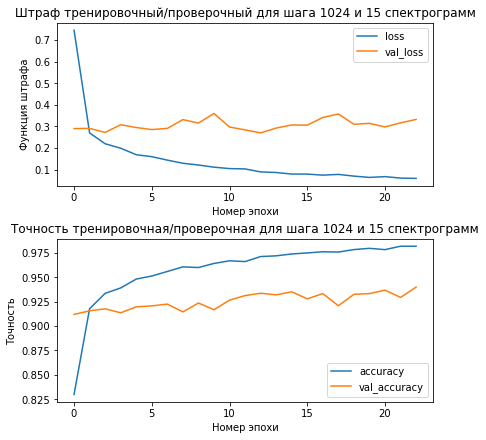

In [71]:
#for k in range(len(params_s_f)):
#for k in range(2):
k = k_max
with open(f'./history_mfcc_{k}_epoch.data', 'rb') as f:
    h_epoch = pickle.load(f)
with open(f'./history_mfcc_{k}_history.data', 'rb') as f:
    h_history = pickle.load(f)
#metrics = histories[k].history
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(h_epoch, h_history['loss'], h_history['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм')

axes[1].plot(h_epoch, h_history['accuracy'], h_history['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм')

In [72]:
print('Лучшие параметры: ', params_s_f[k_max][0],params_s_f[k_max][1])

Лучшие параметры:  1024 15


In [73]:
from tensorflow.keras.models import load_model
train_ds = []
val_ds = []
test_ds = []

spectrogram_ds = preprocess_dataset(train_files,params_s_f[k_max][0],params_s_f[k_max][1])
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files,params_s_f[k_max][0],params_s_f[k_max][1])
test_ds = preprocess_dataset(test_files,params_s_f[k_max][0],params_s_f[k_max][1])

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

model_ = load_model(f"model_mfcc_{k_max}.h5")

y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

85/85 [==============================] - 0s 4ms/step


94.03703703703704

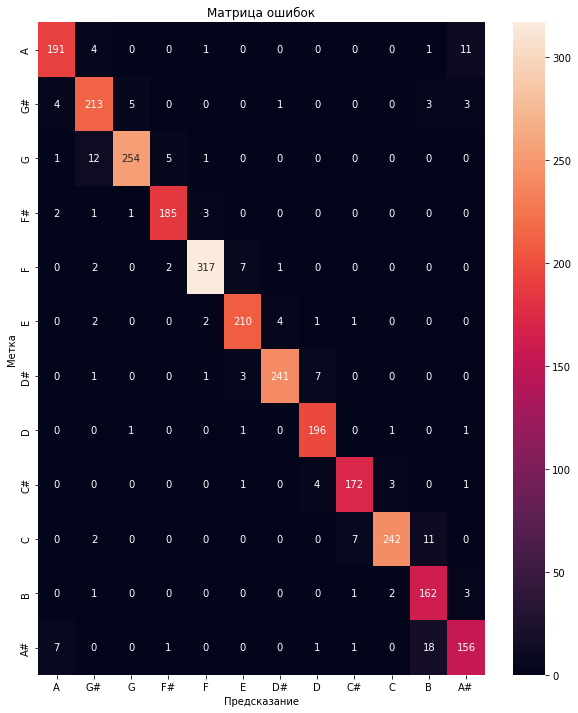

In [74]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

Sample file: D:\magistracy\diplom\records_cut\E\arpeg-CMaj-060BPM-leg_2.wav


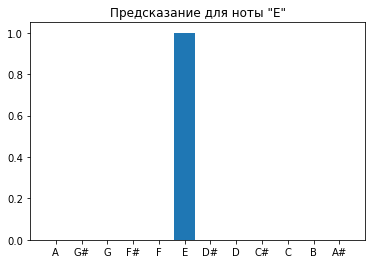

1


In [75]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)

sample_ds = preprocess_dataset([str(sample_file)],params_s_f[k_max][0],params_s_f[k_max][1])
count = 0 
for spectrogram, label in sample_ds.batch(1):
    count+=1
    prediction = model_(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()
print(count)

In [76]:
# Сохраняем модель
model_.save(r"D:\magistracy\diplom\model\model_mfcc_new.h5")

In [77]:
model_.summary()

Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 15, 40)]          0         
                                                                 
 flatten_53 (Flatten)        (None, 600)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               307712    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 839,180
Trainable params: 839,180
Non-traina

C:\Users\belas\AppData\Local\Temp/ipykernel_4128/3168724974.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


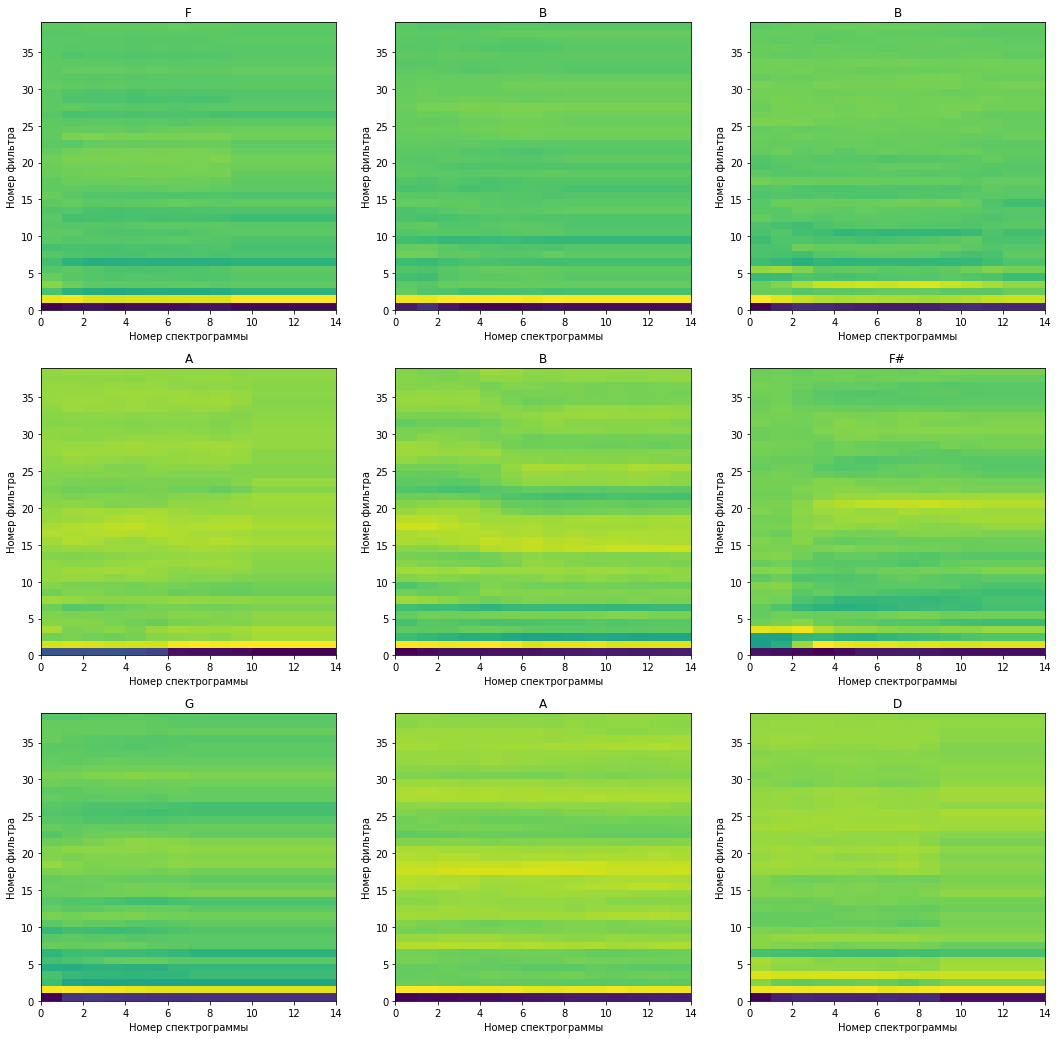

In [78]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    
    plot_spectrogram(np.squeeze(spectrogram.numpy()), axes[r][c])
    axes[r][c].set_title(notes[label_id.numpy()])
    axes[r][c].set_xlabel('Номер спектрограммы')
    axes[r][c].set_ylabel('Номер фильтра')


plt.show()

In [79]:
EPOCHS = 50

for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    print('input_shape',input_shape)

input_shape (15, 40)


In [80]:
print('---------------------------------------------------------------------')
print('Шаг:', params_s_f[k_max][0], ', количество спектрограмм: ',params_s_f[k_max][1])
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

mymodel = create_model(input_shape)

start_time = time.time()
myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)
minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
print(f"--- {minutes} минут {seconds} секунд ---")

metrics = myhistory.history
y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100

print('Шаг:', params_s_f[k_max][0], ', количество спектрограмм: ',params_s_f[k_max][1], ', accuracy тестовой выборки: ', test_acc, '%')

---------------------------------------------------------------------
Шаг: 1024 , количество спектрограмм:  15
2022-06-09 16:59:03
Epoch 1/50
296/296 [==============================] - 25s 83ms/step - loss: 0.6669 - accuracy: 0.8353 - val_loss: 0.2892 - val_accuracy: 0.9126
Epoch 2/50
296/296 [==============================] - 3s 10ms/step - loss: 0.2671 - accuracy: 0.9193 - val_loss: 0.2619 - val_accuracy: 0.9157
Epoch 3/50
296/296 [==============================] - 3s 10ms/step - loss: 0.2240 - accuracy: 0.9322 - val_loss: 0.2797 - val_accuracy: 0.9152
Epoch 4/50
296/296 [==============================] - 3s 10ms/step - loss: 0.1883 - accuracy: 0.9447 - val_loss: 0.2363 - val_accuracy: 0.9320
Epoch 5/50
296/296 [==============================] - 3s 10ms/step - loss: 0.1649 - accuracy: 0.9503 - val_loss: 0.2570 - val_accuracy: 0.9283
Epoch 6/50
296/296 [==============================] - 3s 10ms/step - loss: 0.1552 - accuracy: 0.9508 - val_loss: 0.3117 - val_accuracy: 0.9102
Epoch 7/50

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная для для шага 1024 и 15 спектрограмм на 50 эпохах')]

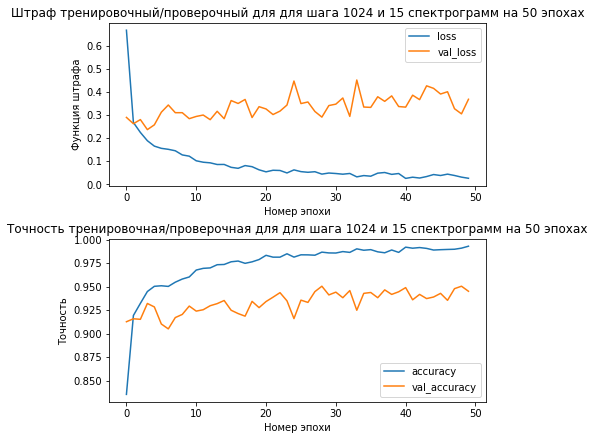

In [81]:
metrics = myhistory.history
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(myhistory.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный для для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм на 50 эпохах')

axes[1].plot(myhistory.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная для для шага {params_s_f[k][0]} и {params_s_f[k][1]} спектрограмм на 50 эпохах')

In [43]:
model_=None